## Importación de dependencias y lectura de datos en bruto

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [8]:
wpp_df = pd.read_excel("../datasets/raw/world_population_prospects/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx", index_col=0)
wpp_df.drop(['Variant','Notes','Location code','ISO3 Alpha-code','ISO2 Alpha-code','SDMX code**','Parent code'],axis=1,inplace=True)

## Vista superficial al dataset

En este dataset se encuentran un gran numero de campos. Estos podrían ser resumidos o cortados posteriormente al limpiar y normalizar los datos para ingresarse a las tablas SQL, quizás mediante su acotación en variables categoricas ordinales, ya que varios son algo redundantes (la tasa de sexo de la población, por ejemplo)

In [106]:
wpp_df

,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 January (thousands)","Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)","Median Age, as of 1 July (years)",...,"Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
Index,,,,,,,,,,,,,,,,,,,,,
1,WORLD,World,1950.0,2477674.732,2499322.157,1245362.965,1253959.192,19.166,99.314,22.224,...,580.75,498.04,240.316,271.625,208.192,378.697,430.259,324.931,0,0
2,WORLD,World,1951.0,2520969.582,2543130.38,1267473.182,1275657.198,19.502,99.358,22.172,...,566.728,490.199,231.177,258.09,203.78,368.319,415.836,319.336,0,0
3,WORLD,World,1952.0,2565291.179,2590270.899,1291399.982,1298870.917,19.864,99.425,22.108,...,546.317,477.264,218.674,240.034,197.142,353.055,395.533,309.91,0,0
4,WORLD,World,1953.0,2615250.618,2640278.797,1316659.222,1323619.574,20.247,99.474,22.036,...,535.829,469.532,212.872,232.602,193.049,345.083,385.843,303.905,0,0
5,WORLD,World,1954.0,2665306.975,2691979.339,1342923.171,1349056.168,20.643,99.545,21.952,...,523.124,458.484,205.762,224.05,187.444,335.442,374.658,295.994,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20592,Wallis and Futuna Islands,Country/Area,2017.0,12.002,11.936,5.769,6.167,85.257,93.562,33.847,...,92.066,102.718,30.643,26.781,33.892,82.852,82.197,83.32,-0.201,-16.706
20593,Wallis and Futuna Islands,Country/Area,2018.0,11.87,11.816,5.703,6.112,84.396,93.301,34.397,...,99.196,89.345,29.201,29.159,29.17,79.633,88.556,72.163,-0.171,-14.368
20594,Wallis and Futuna Islands,Country/Area,2019.0,11.761,11.714,5.648,6.066,83.671,93.109,34.962,...,77.781,80.136,24.304,22.291,25.981,66.639,69.324,64.496,-0.171,-14.489


### Tipos de regiones

En los la columna "Type" del dataset, observamos que los distintos grupos son algo díficiles de generalizar. El grupo "World" se puede extrapolar de los demás datos, el grupo "Label/Separator" es un valor que es inútil para nuestros propositos, y los demás los tendremos que analizar a pie para ver sí vale la pena mantenerlos adentro:

In [107]:
wpp_df.Type.unique()

array(['World', 'Label/Separator', 'SDG region', 'Development Group',
       'Special other', 'Income Group', 'Region', 'Subregion',
       'Country/Area'], dtype=object)

'SDG Region' corresponde a las regiones divididas según aquellas que considera Sustainable Development Goals, un reporte de la división de estadísticas de la UN.

In [108]:
wpp_df[wpp_df.Type == 'SDG region']['Region, subregion, country or area *'].unique()

array(['Sub-Saharan Africa', 'Northern Africa and Western Asia',
       'Central and Southern Asia', 'Eastern and South-Eastern Asia',
       'Latin America and the Caribbean',
       'Oceania (excluding Australia and New Zealand)',
       'Australia/New Zealand', 'Europe and Northern America'],
      dtype=object)

'Region' en este dataset simplemente se refiere a los continentes.

In [109]:
wpp_df[wpp_df.Type == 'Region']['Region, subregion, country or area *'].unique()

array(['AFRICA', 'ASIA', 'EUROPE', 'LATIN AMERICA AND THE CARIBBEAN',
       'NORTHERN AMERICA', 'OCEANIA'], dtype=object)

'Subregion' se refiere, entonces, a las subregiones de estos continentes:

In [110]:
wpp_df[wpp_df.Type == 'Subregion']['Region, subregion, country or area *'].unique()

array(['Eastern Africa', 'Middle Africa', 'Northern Africa',
       'Southern Africa', 'Western Africa', 'Central Asia',
       'Eastern Asia', 'Southern Asia', 'South-Eastern Asia',
       'Western Asia', 'Eastern Europe', 'Northern Europe',
       'Southern Europe', 'Western Europe', 'Caribbean',
       'Central America', 'South America', 'Australia/New Zealand',
       'Melanesia', 'Micronesia', 'Polynesia'], dtype=object)

Las siguientes divide los países según grupos de ingreso y desarrollo economico, sería prudente ponerlos en un dataset separado posteriormente.

In [111]:
wpp_df[wpp_df.Type == 'Special other']['Region, subregion, country or area *'].unique()

array(['Land-locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)'], dtype=object)

In [112]:
wpp_df[wpp_df.Type == 'Income Group']['Region, subregion, country or area *'].unique()

array(['High-income countries', 'Middle-income countries',
       'Upper-middle-income countries', 'Lower-middle-income countries',
       'Low-income countries', 'No income group available'], dtype=object)

In [113]:
wpp_df[wpp_df.Type == 'Development Group']['Region, subregion, country or area *'].unique()

array(['More developed regions', 'Less developed regions',
       'Least developed countries',
       'Less developed regions, excluding least developed countries',
       'Less developed regions, excluding China'], dtype=object)

### Busqueda de valores duplicados o nulos

Buscamos primeros cuales son los valores nulos y en que columnas están:

In [114]:
null_counts = wpp_df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

Year    4
dtype: int64

Evaluemos cuales son estos valores nulos en Year:

In [115]:
wpp_df[pd.to_numeric(wpp_df['Year'], errors='coerce').isnull()]['Year']

Index
73     NaN
650    NaN
1155   NaN
1588   NaN
Name: Year, dtype: float64

In [116]:
wpp_df.loc[[73,650,1155,1588]]

,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 January (thousands)","Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)","Median Age, as of 1 July (years)",...,"Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
Index,,,,,,,,,,,,,,,,,,,,,
73,Sustainable Development Goal (SDG) regions,Label/Separator,NaN,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,UN development groups,Label/Separator,NaN,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,World Bank income groups,Label/Separator,NaN,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,Geographic regions,Label/Separator,NaN,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Son inutiles para nuestro analísis, así que los borraremos sin más.

In [117]:
wpp_df.dropna(inplace=True)

Después, revisaremos los valores duplicados:

In [118]:
wpp_df[wpp_df.duplicated()]

,"Region, subregion, country or area *",Type,Year,"Total Population, as of 1 January (thousands)","Total Population, as of 1 July (thousands)","Male Population, as of 1 July (thousands)","Female Population, as of 1 July (thousands)","Population Density, as of 1 July (persons per square km)","Population Sex Ratio, as of 1 July (males per 100 females)","Median Age, as of 1 July (years)",...,"Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
Index,,,,,,,,,,,,,,,,,,,,,


Finalmente, revisaremos si hay valores no-numericos en las columnas pertinentes:

In [119]:
len(wpp_df[wpp_df.iloc[:,3:57].applymap(np.isreal)])

20592

In [120]:
len(wpp_df)

20592

Ya que no cambia la longitud del dataset al filtrar, podemos deducir que no hay valores no-numericos.

### División de los datasets

In [125]:
dev_wpp_df = wpp_df[(wpp_df.Type == 'Development Group') | (wpp_df.Type == 'Income Group') | (wpp_df.Type == 'Special other')]

In [26]:
reg_wpp_df = wpp_df[(wpp_df.Type != 'World') & (wpp_df.Type != 'Label/Separator') & (wpp_df.Type != 'Development Group') & (wpp_df.Type != 'Income Group') & (wpp_df.Type != 'Special other')]

## Población total

In [127]:
total_popul_df = wpp_df[wpp_df.Type == 'Country/Area'].groupby('Region, subregion, country or area *')['Total Population, as of 1 January (thousands)'].mean().reset_index().sort_values(by='Total Population, as of 1 January (thousands)',ascending=False).head(10)

<AxesSubplot: ylabel='Total Population, as of 1 January (thousands)'>

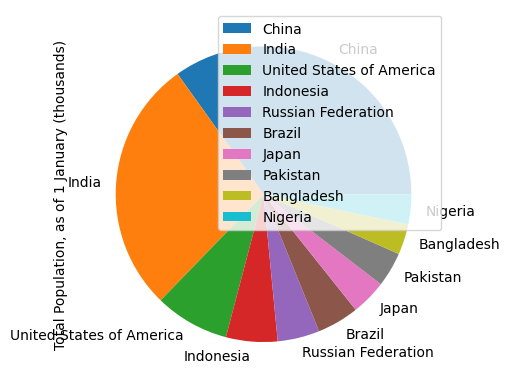

In [128]:
total_popul_df.set_index('Region, subregion, country or area *').plot.pie(y='Total Population, as of 1 January (thousands)')